In [1]:
import pandas as pd
import tqdm
from Bio import SeqIO
import os
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# import keras functions
# import tensorflow
from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, Input, Flatten, LSTM, Dropout, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping

# performance matrices
from sklearn.metrics import confusion_matrix, matthews_corrcoef, accuracy_score

# plots
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Reshape, Lambda, Embedding
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint
import numpy as np
from Bio import SeqIO
from numpy import array
from numpy import argmax
from sklearn.model_selection import train_test_split
from keras import backend as K
from keras.backend import expand_dims
import matplotlib.pyplot as plt
from keras.regularizers import l1, l2


from keras.models import Model
from keras.layers import Concatenate, Dense, LSTM, Input, concatenate


from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold


2022-08-05 09:44:07.241130: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-08-05 09:44:07.245469: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-05 09:44:07.245481: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
def get_input_for_embedding(fasta_file):
    encodings = []
    
    # define universe of possible input values
    alphabet = 'ARNDCQEGHILKMFPSTWYV-'
    
    # define a mapping of chars to integers
    char_to_int = dict((c, i) for i, c in enumerate(alphabet))
    int_to_char = dict((i, c) for i, c in enumerate(alphabet))
    
    for seq_record in SeqIO.parse(fasta_file, "fasta"):
        data = seq_record.seq
        for char in data:
            if char not in alphabet:
                return
        integer_encoded = [char_to_int[char] for char in data]
        encodings.append(integer_encoded)
    encodings = np.array(encodings)
    return encodings

In [3]:
def plot(history):
    # learning curves of model accuracy
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.show()

In [4]:
# convert sequences to integer encoding, for embedding
test_positive_embedding = get_input_for_embedding('data/DeepSuccinylSite/fasta/test_positive_sites.fasta')
test_negative_embedding = get_input_for_embedding('data/DeepSuccinylSite/fasta/test_negative_sites.fasta')
train_positive_embedding = get_input_for_embedding('data/DeepSuccinylSite/fasta/positive_sites.fasta')
train_negative_embedding = get_input_for_embedding('data/DeepSuccinylSite/fasta/negative_sites.fasta')

# create labels
train_positive_labels = np.ones(train_positive_embedding.shape[0])
train_negative_labels = np.zeros(train_negative_embedding.shape[0])
test_positive_labels = np.ones(test_positive_embedding.shape[0])
test_negative_labels = np.zeros(test_negative_embedding.shape[0])

# stack positive and negative data together
X_train_full_embedding = np.vstack((train_positive_embedding,train_negative_embedding))
X_test_embedding = np.vstack((test_positive_embedding,test_negative_embedding))
y_train_full = np.concatenate((train_positive_labels, train_negative_labels), axis = 0)
y_test = np.concatenate((test_positive_labels, test_negative_labels), axis = 0)

train_positive_pt5 = pd.read_csv("data/DeepSuccinylSite/features/full/train_positive_ProtT5-XL-UniRef50.csv", header = None).iloc[:,2:]
train_negative_pt5 = pd.read_csv("data/DeepSuccinylSite/features/full/train_negative_ProtT5-XL-UniRef50.csv", header = None).iloc[:,2:]
test_positive_pt5 = pd.read_csv("data/DeepSuccinylSite/features/full/test_positive_ProtT5-XL-UniRef50.csv", header = None).iloc[:,2:]
test_negative_pt5 = pd.read_csv("data/DeepSuccinylSite/features/full/test_negative_ProtT5-XL-UniRef50.csv", header = None).iloc[:,2:]

# stack positive and negative data together
X_train_pt5_full = np.vstack((train_positive_pt5,train_negative_pt5))
X_test_pt5 = np.vstack((test_positive_pt5,test_negative_pt5))


In [5]:
def CNN_Embedding():
    # Embedding
    model = Sequential()
    model.add(Embedding(256, 21, input_length=33))
    model.add(Lambda(lambda x: K.expand_dims(x, 3)))
    model.add(Conv2D(32, kernel_size=(17, 3), activation = 'relu', kernel_initializer='he_normal', padding = 'VALID'))
    model.add(Dropout(0.2))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(16, activation='relu', kernel_initializer='he_normal'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [58]:
m1 = CNN_Embedding()
m1.summary()

Model: "sequential_524"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_524 (Embedding)   (None, 33, 21)            5376      
                                                                 
 lambda_524 (Lambda)         (None, 33, 21, 1)         0         
                                                                 
 conv2d_524 (Conv2D)         (None, 17, 19, 32)        1664      
                                                                 
 dropout_2105 (Dropout)      (None, 17, 19, 32)        0         
                                                                 
 max_pooling2d_524 (MaxPooli  (None, 8, 9, 32)         0         
 ng2D)                                                           
                                                                 
 flatten_524 (Flatten)       (None, 2304)              0         
                                                    

In [16]:
def ANN():
    # prot_t5
    M1_input = Input(shape=(1024,))
    M1_dense_1 = Dense(256)(M1_input)
    drop_out = Dropout(0.4)(M1_dense_1)
   
    M1_dense_2 = Dense(128, activation='relu')(drop_out)
    drop_out = Dropout(0.2)(M1_dense_2)
    
#     M1_dense_2 = Dense(64, activation='relu')(drop_out)
#     leaky_relu = LeakyReLU(alpha=0.3)(M1_dense_2)
#     drop_out = Dropout(0.7)(leaky_relu)
    
    M1_dense_3 = Dense(1, activation = 'sigmoid')(drop_out)
    model = Model(inputs=M1_input, outputs=M1_dense_3)
    return model

In [17]:
# load models from file
def load_all_models(model_names):
    from keras import backend as K
    all_models = list()
    
    for model in model_names:
        filename = 'selected_models/'+ model + '.h5'
        model = load_model(filename, custom_objects={"K": K})
        all_models.append(model)
        print('>loaded %s' % filename)
    return all_models


# meta learner
def define_stacked_model(members):
    for i in range(len(members)):
        model = members[i]
        for layer in model.layers:
            layer.trainable = False
    ensemble_visible = [model.input for model in members]
    ensemble_outputs = [model.output for model in members]
    merge = concatenate(ensemble_outputs)
    hidden = Dense(16, activation='relu')(merge)
    # hidden = Dropout(0.1)(hidden)
    hidden = Dense(4, activation='relu')(hidden)
    # hidden = Dropout(0.2)(hidden)
    output = Dense(1, activation='sigmoid')(hidden)
    model = Model(inputs=ensemble_visible, outputs=output)
    plot_model(model, show_shapes=True, to_file='ensemble_graph.png')
    model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=Adam(learning_rate =0.0001))
    return model


# fit a model
def fit_stacked_model(model, inputX, inputy):
    X = [inputX for _ in range(len(model.input))]
    inputy_enc = to_categorical(inputy)
    model.fit(X, inputy_enc, epochs=15, verbose=1)   

# prediction
def predict_stacked_model(model, inputX):
    X = [inputX for _ in range(len(model.input))]
    return model.predict(X, verbose=0)



In [51]:
from sklearn.utils import shuffle 

training_data = [0.2, 0.4, 0.6, 0.8]

# shuffle
X_train_full_embedding, X_train_pt5_full, y_train_full = shuffle(
    X_train_full_embedding,
    X_train_pt5_full,
    y_train_full
)


for datasize in training_data:
    # split data, ignore val data
    X_train_new_embedding, _dummy, X_train_new_pt5, _dummy2, y_train_new, _dummy3  = train_test_split(
        X_train_full_embedding,
        X_train_pt5_full,
        y_train_full,
        test_size = (1-datasize),
        stratify = y_train_full
    )
    
    # print(X_train_new_embedding.shape, X_train_new_pt5.shape, y_train_new.shape)
    
    
    # set k-fold config
    kfold = StratifiedKFold(10, shuffle=True)

    # initialize average variables
    avg_acc, avg_mcc, avg_sp, avg_sn = 0, 0, 0, 0

    for train, val in kfold.split(X_train_new_embedding, y_train_new):
        
        # seperate val data
        X_train_embedding, X_val_embedding = X_train_new_embedding[train], X_train_new_embedding[val]
        y_train, y_val = y_train_new[train], y_train_new[val]
        X_train_pt5, X_val_pt5 = X_train_new_pt5[train], X_train_new_pt5[val]
        
        # Early stopping
        es = EarlyStopping(monitor='val_accuracy', patience=7, mode='auto')
        
        # Checkpointer
        metric = 'val_accuracy'
        checkpointer = ModelCheckpoint(filepath="models/st_model_best.h5",
                                monitor = metric,
                                verbose=0, 
                                save_weights_only=False,
                                save_best_only=True)
        ## Embedding Model
        model_1 = CNN_Embedding()
        model_1.compile(optimizer=Adam(learning_rate=1e-3),
                  loss=BinaryCrossentropy(),
                  metrics=['accuracy'])
       
        # Training
        history_1 = model_1.fit(X_train_embedding, y_train, batch_size=256, epochs=100, verbose=0, callbacks=[es], validation_data=(X_val_embedding, y_val))
        
        ## ANN Model
        model_2 = ANN()
        model_2.compile(optimizer=Adam(learning_rate=1e-3),
                  loss=BinaryCrossentropy(),
                  metrics=['accuracy'])
        
        # Training
        history_2 = model_2.fit(X_train_pt5, y_train, batch_size=256, epochs=60, verbose=0, callbacks=[es],
                                validation_data=(X_val_pt5, y_val))
        
        
        # create truncated models
        ANN_new = Model(inputs=model_2.input,
                                         outputs=model_2.get_layer(index=4).output)

        Embedding_new = Model(inputs=model_1.input,
                                         outputs=model_1.get_layer(index=6).output)
        
        stacked_model = define_stacked_model([Embedding_new, ANN_new])
        
        # fit_stacked_model(stacked_model, x_test, y_test)
        history = stacked_model.fit([X_train_embedding, X_train_pt5] , 
                                    y_train, 
                                    callbacks = [es],
                                    epochs=50,
                                    verbose=0,
                                    validation_data = ([X_val_embedding, X_val_pt5], y_val)
                                   )

        y_pred = stacked_model.predict([X_val_embedding, X_val_pt5]).reshape(y_val.shape[0],)
        y_pred = (y_pred > 0.5)
        y_pred = [int(i) for i in y_pred]
        y_val = np.array(y_val)
        y_pred = np.array(y_pred)

        cm = confusion_matrix(y_val, y_pred)
        mcc = matthews_corrcoef(y_val, y_pred)
        acc = accuracy_score(y_val, y_pred)

        sn = cm[1][1]/(cm[1][1]+cm[1][0])
        sp = cm[0][0]/(cm[0][0]+cm[0][1])
       
        avg_acc += acc
        avg_mcc += mcc
        avg_sn += sn
        avg_sp += sp
        
        # plot(history)
        print("\n %s, %s, %s, %s, %s \n" %(str(acc), str(mcc), str(sn), str(sp), cm))
    print("---------")
    print("\n %s, %s, %s, %s \n" %(str(avg_acc/10), str(avg_mcc/10), str(avg_sn/10), str(avg_sp/10)))
    print("---------")

6/6 [==============================] - 0s 3ms/step

 0.6157894736842106, 0.2315917782932927, 0.6105263157894737, 0.6210526315789474, [[59 36]
 [37 58]] 

6/6 [==============================] - 0s 4ms/step

 0.6736842105263158, 0.34930904185647565, 0.7263157894736842, 0.6210526315789474, [[59 36]
 [26 69]] 

6/6 [==============================] - 0s 3ms/step

 0.7526315789473684, 0.5055152782453616, 0.7684210526315789, 0.7368421052631579, [[70 25]
 [22 73]] 

6/6 [==============================] - 0s 2ms/step

 0.6684210526315789, 0.33686076842660756, 0.6631578947368421, 0.6736842105263158, [[64 31]
 [32 63]] 

6/6 [==============================] - 0s 3ms/step

 0.7368421052631579, 0.473789217003005, 0.7473684210526316, 0.7263157894736842, [[69 26]
 [24 71]] 

6/6 [==============================] - 0s 4ms/step

 0.6947368421052632, 0.38981938376529196, 0.6736842105263158, 0.7157894736842105, [[68 27]
 [31 64]] 

6/6 [==============================] - 0s 3ms/step

 0.7105263157894737, 0

### for 100% data

In [57]:
from sklearn.utils import shuffle 

training_data = [1]

# shuffle
X_train_new_embedding, X_train_new_pt5, y_train_new = shuffle(
    X_train_full_embedding,
    X_train_pt5_full,
    y_train_full
)


for datasize in training_data:
   
    # set k-fold config
    kfold = StratifiedKFold(10, shuffle=True)

    # initialize average variables
    avg_acc, avg_mcc, avg_sp, avg_sn = 0, 0, 0, 0

    for train, val in kfold.split(X_train_new_embedding, y_train_new):
        
        # seperate val data
        X_train_embedding, X_val_embedding = X_train_new_embedding[train], X_train_new_embedding[val]
        y_train, y_val = y_train_new[train], y_train_new[val]
        X_train_pt5, X_val_pt5 = X_train_new_pt5[train], X_train_new_pt5[val]
        
        # Early stopping
        es = EarlyStopping(monitor='val_accuracy', patience=7, mode='auto')
        
        # Checkpointer
        metric = 'val_accuracy'
        checkpointer = ModelCheckpoint(filepath="models/st_model_best.h5",
                                monitor = metric,
                                verbose=0, 
                                save_weights_only=False,
                                save_best_only=True)
        ## Embedding Model
        model_1 = CNN_Embedding()
        model_1.compile(optimizer=Adam(learning_rate=1e-3),
                  loss=BinaryCrossentropy(),
                  metrics=['accuracy'])
       
        # Training
        history_1 = model_1.fit(X_train_embedding, y_train, batch_size=256, epochs=100, verbose=0, callbacks=[es], validation_data=(X_val_embedding, y_val))
        
        ## ANN Model
        model_2 = ANN()
        model_2.compile(optimizer=Adam(learning_rate=1e-3),
                  loss=BinaryCrossentropy(),
                  metrics=['accuracy'])
        
        # Training
        history_2 = model_2.fit(X_train_pt5, y_train, batch_size=256, epochs=60, verbose=0, callbacks=[es],
                                validation_data=(X_val_pt5, y_val))
        
        
        # create truncated models
        ANN_new = Model(inputs=model_2.input,
                                         outputs=model_2.get_layer(index=4).output)

        Embedding_new = Model(inputs=model_1.input,
                                         outputs=model_1.get_layer(index=6).output)
        
        stacked_model = define_stacked_model([Embedding_new, ANN_new])
        
        # fit_stacked_model(stacked_model, x_test, y_test)
        history = stacked_model.fit([X_train_embedding, X_train_pt5] , 
                                    y_train, 
                                    callbacks = [es],
                                    epochs=50,
                                    verbose=0,
                                    validation_data = ([X_val_embedding, X_val_pt5], y_val)
                                   )

        y_pred = stacked_model.predict([X_val_embedding, X_val_pt5]).reshape(y_val.shape[0],)
        y_pred = (y_pred > 0.5)
        y_pred = [int(i) for i in y_pred]
        y_val = np.array(y_val)
        y_pred = np.array(y_pred)

        cm = confusion_matrix(y_val, y_pred)
        mcc = matthews_corrcoef(y_val, y_pred)
        acc = accuracy_score(y_val, y_pred)

        sn = cm[1][1]/(cm[1][1]+cm[1][0])
        sp = cm[0][0]/(cm[0][0]+cm[0][1])
       
        avg_acc += acc
        avg_mcc += mcc
        avg_sn += sn
        avg_sp += sp
        
        # plot(history)
        print("\n %s, %s, %s, %s, %s \n" %(str(acc), str(mcc), str(sn), str(sp), cm))
    print("---------")
    print("\n %s, %s, %s, %s \n" %(str(avg_acc/10), str(avg_mcc/10), str(avg_sn/10), str(avg_sp/10)))
    print("---------")

30/30 [==============================] - 0s 3ms/step

 0.7536842105263157, 0.5081302020869845, 0.7810526315789473, 0.7263157894736842, [[345 130]
 [104 371]] 

30/30 [==============================] - 0s 4ms/step

 0.7789473684210526, 0.5586082303781733, 0.8042105263157895, 0.7536842105263157, [[358 117]
 [ 93 382]] 

30/30 [==============================] - 0s 4ms/step

 0.7726315789473684, 0.546665388852788, 0.8084210526315789, 0.7368421052631579, [[350 125]
 [ 91 384]] 

30/30 [==============================] - 0s 4ms/step

 0.7726315789473684, 0.545960496860177, 0.7978947368421052, 0.7473684210526316, [[355 120]
 [ 96 379]] 

30/30 [==============================] - 0s 4ms/step

 0.7652631578947369, 0.5306686305052324, 0.7536842105263157, 0.7768421052631579, [[369 106]
 [117 358]] 

30/30 [==============================] - 0s 4ms/step

 0.7652631578947369, 0.530536897240315, 0.7684210526315789, 0.7621052631578947, [[362 113]
 [110 365]] 

30/30 [==============================] - 0s

In [59]:
# plot in graph

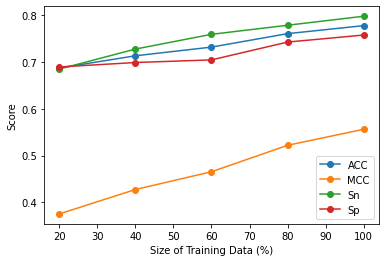

In [6]:
acc = [0.6871929825,0.7133363422,0.731886042,0.7606284238,0.7777660695]
mcc = [0.3753616344,0.4275115796,0.4655037853,0.5220351587,0.5562980746]
sn = [0.6849160134,0.7277025898,0.7592092908,0.7786279683,0.7978507662]
sp = [0.6894736842, 0.6989473684,0.7045614035,0.7426315789,0.7576842105]
x = [20,40,60,80,100]

import matplotlib.pyplot as plt
import numpy as np


plt.plot(x,acc, marker = 'o', label = 'ACC')
plt.plot(x,mcc, marker = 'o', label = 'MCC')
plt.plot(x,sn, marker = 'o', label = 'Sn')
plt.plot(x,sp, marker = 'o', label = 'Sp')

plt.legend()
plt.xlabel("Size of Training Data (%)")
plt.ylabel("Score")
plt.savefig('Sensitivity.png', dpi = 600)
plt.show()